In [2]:
from sklearn.metrics import (ConfusionMatrixDisplay,classification_report,confusion_matrix)
from sklearn.model_selection import GridSearchCV, train_test_split,cross_val_score 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import make_pipeline 
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from scipy.io.arff import loadarff 
import xgboost as xgb
import pickle
import pandas as pd
import numpy as np

In [7]:
df = pd.read_csv('/home/mussie/Videos/exam_prep/data/churn-bigml-20.csv')


In [8]:
df.head(3)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
1,IN,65,415,No,No,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True
2,NY,161,415,No,No,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,True


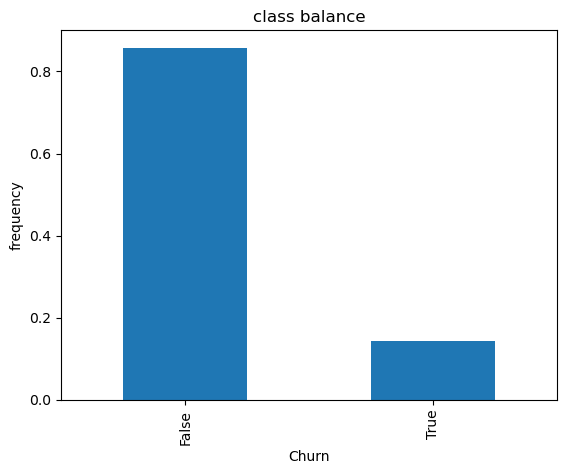

In [9]:
# Plot class balance
df['Churn'].value_counts(normalize=True).plot(
    kind="bar",xlabel='Churn',ylabel='frequency',title='class balance'
); 
  

In [10]:
feature = ['Account length', 'Area code',
         'Total day minutes',
       'Total intl calls', 'Total intl charge', 'Customer service calls' ]
target= ['Churn']

X = df[feature]
y =df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (667, 6)
y shape: (667, 1)


In [11]:
# Step 1: Calculate the Z-scores for each feature
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
X_train, X_test, y_train, y_test = X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [9]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (533, 6)
y_train shape: (533, 1)
X_test shape: (134, 6)
y_test shape: (134, 1)


In [10]:
#counting values
y_train.value_counts()

Churn
False    453
True      80
dtype: int64

In [11]:
over_sampler = RandomOverSampler()
X_train_o, y_train_o = over_sampler.fit_resample(X_train,y_train)
print("X_train_over shape:", X_train_o.shape)
X_train_o.head(2)

X_train_over shape: (906, 6)


,Account length,Area code,Total day minutes,Total intl calls,Total intl charge,Customer service calls
0,55,510,189.0,6,4.62,0
1,100,408,70.8,1,2.57,6


In [25]:
y_train_o.value_counts()

Churn
False    453
True     453
dtype: int64

In [13]:
# create an instance of LabelEncoder
le = LabelEncoder()

# fit and transform the encoder to the target variable
y_train = le.fit_transform(y_train_o)
y_test = le.transform(y_test)

c:\Users\mussie\anaconda3\envs\examm\Lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mussie\anaconda3\envs\examm\Lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [11]:
#or use this 

from sklearn.preprocessing import LabelEncoder

# create an instance of LabelEncoder
le = LabelEncoder()

# reshape target variables to avoid DataConversionWarning
y_train = y_train_o['Churn'].values.reshape(-1, 1)
y_test = y_test['Churn'].values.reshape(-1, 1)

# fit and transform the encoder to the target variable
y_train = le.fit_transform(y_train.ravel())
y_test = le.transform(y_test.ravel())

In [14]:
import numpy as np

# calculate the frequency of each label
counts = np.bincount(y_train)

# calculate the baseline accuracy as the fraction of the most frequent label
acc_baseline = counts.max() / len(y_train)

print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.5


#Model ensemble

In [15]:

knn = KNeighborsClassifier()
params_knn = {'n_neighbors': np.arange(1, 25)}
knn_gs = GridSearchCV(knn, params_knn, cv=5)
knn_gs.fit(X_train_o,y_train)
knn_best = knn_gs.best_estimator_


In [16]:
knn_best

KNeighborsClassifier(n_neighbors=1)

In [17]:
rf = RandomForestClassifier(random_state=0)
params_rf = {'n_estimators': [50, 100, 200]}
rf_gs = GridSearchCV(rf, params_rf, cv=5)
rf_gs.fit(X_train_o,y_train)
rf_best = rf_gs.best_estimator_


In [18]:
log_reg = LogisticRegression(random_state=123, solver='liblinear', penalty='l2', max_iter=5000)
C = np.logspace(1, 4, 10)
params_lr = dict(C=C)
lr_gs = GridSearchCV(log_reg, params_lr, cv=5, verbose=0)
lr_gs.fit(X_train_o,y_train)
lr_best = lr_gs.best_estimator_


In [19]:
from sklearn.ensemble import VotingClassifier
estimators = [('knn', knn_best), ('rf', rf_best), ('log_reg', lr_best)]
ensemble = VotingClassifier(estimators, voting='soft')
ensemble.fit(X_train_o,y_train)


VotingClassifier(estimators=[('knn', KNeighborsClassifier(n_neighbors=1)),
                             ('rf',
                              RandomForestClassifier(n_estimators=200,
                                                     random_state=0)),
                             ('log_reg',
                              LogisticRegression(C=10.0, max_iter=5000,
                                                 random_state=123,
                                                 solver='liblinear'))],
                 voting='soft')

In [35]:
y_pred = ensemble.predict(X_test)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8432835820895522


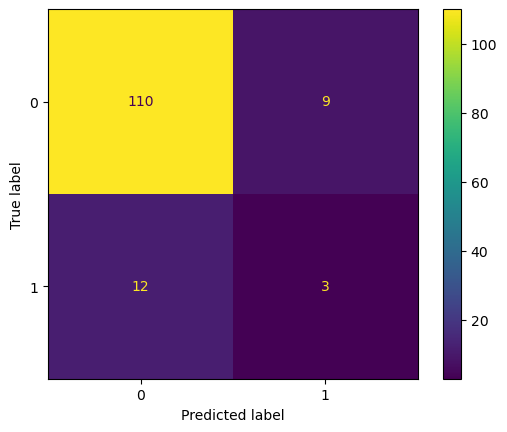

In [21]:
#plot a confusion matrix that shows how your best model performs on your test set.
ConfusionMatrixDisplay.from_estimator(ensemble,X_test,y_test)    
     

In [22]:
# compute the classification report
report = classification_report(y_test, y_pred, target_names=['No churn', 'Churn'])

# print the report
print(report)

              precision    recall  f1-score   support

    No churn       0.90      0.92      0.91       119
       Churn       0.25      0.20      0.22        15

    accuracy                           0.84       134
   macro avg       0.58      0.56      0.57       134
weighted avg       0.83      0.84      0.84       134



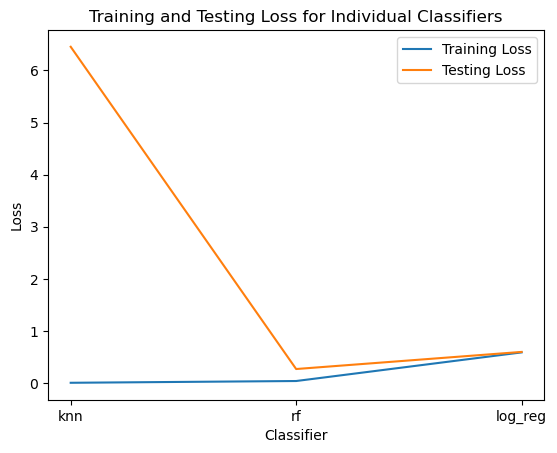

In [53]:
classifiers = [knn_best, rf_best, lr_best]
classifier_names = ['knn', 'rf', 'log_reg']

train_losses = []
test_losses = []

for classifier, name in zip(classifiers, classifier_names):
    classifier.fit(X_train_o, y_train)
    y_train_pred = classifier.predict_proba(X_train_o)
    y_test_pred = classifier.predict_proba(X_test)
    
    train_loss = log_loss(y_train, y_train_pred)
    test_loss = log_loss(y_test, y_test_pred)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)

# Plot the losses
plt.plot(classifier_names, train_losses, label='Training Loss')
plt.plot(classifier_names, test_losses, label='Testing Loss')
plt.xlabel('Classifier')
plt.ylabel('Loss')
plt.title('Training and Testing Loss for Individual Classifiers')
plt.legend()
plt.show()


In [23]:
#saving model to a file
with open("model.2.pkl","wb") as f:
  pickle.dump(ensemble,f)

#Xgboost

In [26]:
D_train = xgb.DMatrix(X_train_o, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

In [46]:
clf = xgb.XGBClassifier()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }

grid = GridSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="neg_log_loss",
                    cv=3)
# Fit the model using GridSearchCV with eval_set parameter
clf = grid.fit(X_train_o, y_train, eval_set=[(X_train_o, y_train), (X_test, y_test)], verbose=False)

#clf = grid.fit(X_train_o, y_train)

In [47]:

# Predict on test data
y_pred_xgb = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_xgb)
print("Accuracy:", accuracy)

Accuracy: 0.9104477611940298


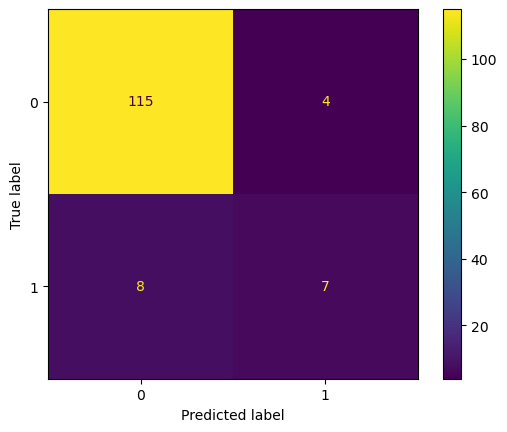

In [48]:
#plot a confusion matrix that shows how your best model performs on your test set.
ConfusionMatrixDisplay.from_estimator(clf,X_test,y_test)  

In [49]:
# compute the classification report
report = classification_report(y_test, y_pred_xgb, target_names=['No churn', 'Churn'])

# print the report
print(report)

              precision    recall  f1-score   support

    No churn       0.93      0.97      0.95       119
       Churn       0.64      0.47      0.54        15

    accuracy                           0.91       134
   macro avg       0.79      0.72      0.74       134
weighted avg       0.90      0.91      0.90       134



In [50]:
best_estimator = clf.best_estimator_

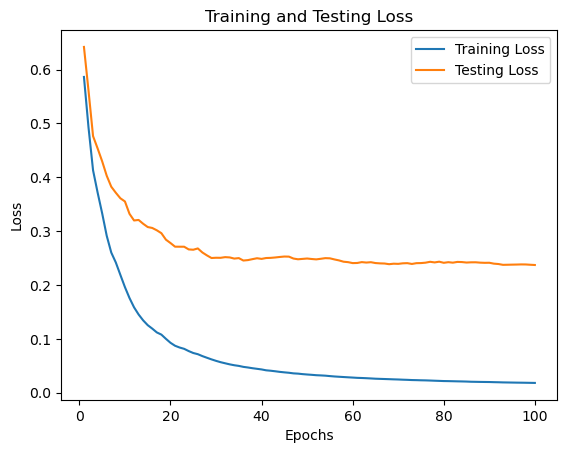

In [51]:
# Obtain the best estimator from GridSearchCV
best_estimator = clf.best_estimator_

# Obtain training loss
train_loss = best_estimator.evals_result()['validation_0']['logloss']

# Obtain testing loss
test_loss = best_estimator.evals_result()['validation_1']['logloss']

# Create data for plotting
epochs = range(1, len(train_loss) + 1)

# Plot the loss
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, test_loss, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()
